In [46]:
# Initial imports and variable declarations

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import glob
import os
import re
from multiprocessing import Pool
import seaborn as sns
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
import re
import datetime
from afinn import Afinn
from empath import Empath
import matplotlib.pyplot as plt
%matplotlib inline
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic
from scipy import stats
import patsy
from statsmodels.genmod.families import Poisson

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")
sns.set_theme(style="whitegrid")

DATA_DIR = "../data/"

In [4]:
# Load the quotes mentionning the movies in the boxoffice top 50 
df_quote = pd.read_csv(DATA_DIR + "50moviesquotes.csv.gz", on_bad_lines="warn")
df_quote.head()

,Unnamed: 0,Unnamed: 0.1,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,primaryTitle
0,0,6492,2015-12-31-028469,I want to clarify my interview on the `Charlie...,George Lucas,"['Q1507803', 'Q38222']",2015-12-31 16:48:00,7,"[['George Lucas', '0.5327'], ['None', '0.4248'...",['http://www.escapistmagazine.com/news/view/16...,E,Star Wars: Episode VII - The Force Awakens
1,1,9488,2015-12-18-058761,"It's the dawn of a new Star Wars era,",None,[],2015-12-18 12:55:59,1,"[['None', '0.9462'], ['george lucas', '0.0538']]",['http://carbonated.tv/viral/australian-couple...,E,Star Wars: Episode VII - The Force Awakens
2,2,11653,2015-12-21-084512,"They were saying, `Well, since when has Star W...",J.J. Abrams,['Q188137'],2015-12-21 08:04:49,1,"[['J.J. Abrams', '0.5868'], ['None', '0.2584']...",['http://rssfeeds.usatoday.com/~/129385923/0/u...,E,Star Wars: Episode VII - The Force Awakens
3,3,16795,2015-12-16-003799,Advertisers that used the force ahead of the S...,None,[],2015-12-16 22:57:43,1,"[['None', '0.8848'], ['Laurent Simon', '0.1152']]",['http://www.adweek.com/agencyspy/wednesday-od...,E,Star Wars: Episode VII - The Force Awakens
4,4,34090,2015-12-16-097475,The first Star Wars film was widely advertised...,Andy Summers,['Q315758'],2015-12-16 05:13:50,1,"[['Andy Summers', '0.6693'], ['None', '0.2707'...",['http://bournemouthecho.co.uk/news/14146562.T...,E,Star Wars: Episode VII - The Force Awakens


In [5]:
# Only keep interesting columns
df_quote = df_quote[["quotation", "speaker", "date", "numOccurrences", "primaryTitle"]]
df_quote.head()

,quotation,speaker,date,numOccurrences,primaryTitle
0,I want to clarify my interview on the `Charlie...,George Lucas,2015-12-31 16:48:00,7,Star Wars: Episode VII - The Force Awakens
1,"It's the dawn of a new Star Wars era,",None,2015-12-18 12:55:59,1,Star Wars: Episode VII - The Force Awakens
2,"They were saying, `Well, since when has Star W...",J.J. Abrams,2015-12-21 08:04:49,1,Star Wars: Episode VII - The Force Awakens
3,Advertisers that used the force ahead of the S...,None,2015-12-16 22:57:43,1,Star Wars: Episode VII - The Force Awakens
4,The first Star Wars film was widely advertised...,Andy Summers,2015-12-16 05:13:50,1,Star Wars: Episode VII - The Force Awakens


In [6]:
# Load the data on movies and boxoffice
df_movie = pd.read_csv(DATA_DIR + 'movie_data_2015_2020.csv', on_bad_lines="warn")
df_movie.head()

,Unnamed: 0,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,...,ordering_y,nconst,category,job,characters,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,0,tt1179933,movie,10 Cloverfield Lane,10 Cloverfield Lane,0.0,2016.0,NaN,103.0,"Action,Drama,Horror",...,10.0,nm6618222,producer,producer,NaN,Lindsey Weber,NaN,NaN,producer,"tt4530422,tt2660888,tt2548396,tt1179933"
1,1,tt4530422,movie,Overlord,Overlord,0.0,2018.0,NaN,110.0,"Action,Horror,Sci-Fi",...,9.0,nm6618222,producer,producer,NaN,Lindsey Weber,NaN,NaN,producer,"tt4530422,tt2660888,tt2548396,tt1179933"
2,2,tt1179933,movie,10 Cloverfield Lane,10 Cloverfield Lane,0.0,2016.0,NaN,103.0,"Action,Drama,Horror",...,1.0,nm0000422,actor,NaN,"[""Howard""]",John Goodman,1952.0,NaN,"actor,soundtrack,producer","tt0101410,tt1179933,tt1024648,tt1907668"
3,3,tt2406566,movie,Atomic Blonde,Atomic Blonde,0.0,2017.0,NaN,115.0,"Action,Thriller",...,3.0,nm0000422,actor,NaN,"[""Emmett Kurzfeld""]",John Goodman,1952.0,NaN,"actor,soundtrack,producer","tt0101410,tt1179933,tt1024648,tt1907668"
4,4,tt5968394,movie,Captive State,Captive State,0.0,2019.0,NaN,109.0,"Action,Horror,Sci-Fi",...,1.0,nm0000422,actor,NaN,"[""William Mulligan""]",John Goodman,1952.0,NaN,"actor,soundtrack,producer","tt0101410,tt1179933,tt1024648,tt1907668"


In [7]:
# Only keep interesting columns
df_movie = df_movie[["primaryTitle", "startYear", "genres", "Total Gross"]]
df_movie.drop_duplicates(keep="first", inplace=True)
df_movie.head()

,primaryTitle,startYear,genres,Total Gross
0,10 Cloverfield Lane,2016.0,"Action,Drama,Horror","$72,082,998"
1,Overlord,2018.0,"Action,Horror,Sci-Fi","$21,704,844"
3,Atomic Blonde,2017.0,"Action,Thriller","$51,687,870"
4,Captive State,2019.0,"Action,Horror,Sci-Fi","$5,958,315"
5,Love the Coopers,2015.0,"Comedy,Fantasy,Romance","$26,302,731"


In [8]:
# Merge both datasets, to have quotes with movie and boxoffice information together
df_total = pd.merge(df_quote, df_movie, on=["primaryTitle"])
df_total.head(50)

,quotation,speaker,date,numOccurrences,primaryTitle,startYear,genres,Total Gross
0,I want to clarify my interview on the `Charlie...,George Lucas,2015-12-31 16:48:00,7,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
1,"It's the dawn of a new Star Wars era,",None,2015-12-18 12:55:59,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
2,"They were saying, `Well, since when has Star W...",J.J. Abrams,2015-12-21 08:04:49,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
3,Advertisers that used the force ahead of the S...,None,2015-12-16 22:57:43,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
4,The first Star Wars film was widely advertised...,Andy Summers,2015-12-16 05:13:50,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
5,We struck a licensing deal with Disney a few y...,None,2015-11-17 01:17:00,5,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
6,"Disney has a lot of momentum right now, and it...",None,2015-08-10 10:40:17,4,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
7,"It's the third one, and I think that's pushing...",Paul Howard,2015-12-18 12:47:31,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
8,"When I started to go into Star Wars, [ my frie...",George Lucas,2015-12-31 21:23:39,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"
9,But they are unlikely to match the might of th...,Andreas Wiseman,2015-12-29 23:09:16,4,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225"


In [9]:
# Extract the int value from the total gross
def revenue_clean(data):
    return str(data).replace('$', '').replace(',', '')

df_total["revenue"] = df_total["Total Gross"].progress_apply(revenue_clean)
df_total["revenue"] = df_total["revenue"].astype(int)

df_total.dtypes

  0%|          | 0/932018 [00:00<?, ?it/s]

quotation          object
speaker            object
date               object
numOccurrences      int64
primaryTitle       object
startYear         float64
genres             object
Total Gross        object
revenue             int64
dtype: object

In [10]:
# Compute the median of the total gross
MED_REVENUE = int(df_total["revenue"].median())
print(MED_REVENUE)

270395425


In [12]:
# Split the movies in two categories, high and low box office revenue

def revenue_to_str(val):
    if val > MED_REVENUE:
        return "high"
    return "low"

df_total["success"] = df_total["revenue"].map(revenue_to_str)
df_total.drop_duplicates(inplace=True)
df_total

,quotation,speaker,date,numOccurrences,primaryTitle,startYear,genres,Total Gross,revenue,success
0,I want to clarify my interview on the `Charlie...,George Lucas,2015-12-31 16:48:00,7,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high
1,"It's the dawn of a new Star Wars era,",None,2015-12-18 12:55:59,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high
2,"They were saying, `Well, since when has Star W...",J.J. Abrams,2015-12-21 08:04:49,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high
3,Advertisers that used the force ahead of the S...,None,2015-12-16 22:57:43,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high
4,The first Star Wars film was widely advertised...,Andy Summers,2015-12-16 05:13:50,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high
...,...,...,...,...,...,...,...,...,...,...
932013,evil versions of Wonder Woman and other member...,Barry Allen,2018-02-22 17:11:40,1,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,low
932014,We saw a glimpse of it in the nightmare sequen...,Michael Wilkinson,2018-03-23 15:30:59,1,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,low
932015,Will Australia get Justice League?,Owen Gleiberman,2018-04-16 13:57:35,2,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,low
932016,Justice League has been the golden ring for me...,Scott Snyder,2018-03-19 13:03:21,10,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,low


In [13]:
nlp = en_core_web_sm.load()

punctuations = string.punctuation
#stopwords = list(STOP_WORDS)

parser = nlp
# Tokenize the given sentence
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in punctuations ]
    tokens = " ".join([i for i in tokens])
    return tokens

In [24]:
# https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
def parallelize_dataframe(df, func, n_cores=8, merger=pd.concat):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = merger(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [33]:
# Apply the tokenization function above on all the quotes
# Takes around 25min with 8 cores

def get_text_clean(df):
    df["text_clean"] = df["quotation"].progress_apply(spacy_tokenizer)
    df["text"] = df["text_clean"].astype('str')
    return df
    
df_total = parallelize_dataframe(df_total, get_text_clean)   

In [14]:
# Export the tokenized quotes to a separate dataset 
df_total.to_csv(DATA_DIR + 'text_clean.csv.gz')
# Load the quotes
#df_total = pd.read_csv(DATA_DIR + 'text_clean.csv.gz')

**Dataset can be downloaded here:**
https://drive.google.com/drive/folders/1Kwv7boEYxS1DRev6KCIJLhoYiBRBMHUV?usp=sharing

In [26]:
# Run sentiment analysis

lexicon = Empath()

sentiments = ["warmth", "fun", "emotional", "disappointment", "love", "hate"]

# Flatten a list of list by one level
def flatten(l):
    acc = []
    for sub in l:
        acc.extend(sub)
    return acc

def lexicon_analyze(df):
    print(f"Lexicon analyze starts {df.shape[0]}")
    results=[]
    # Analyze lexicon for each row
    #pbar = tqdm(df["text"])
    for i in df["text"]:
        #pbar.set_description(f"lexicon analyze {len(results)} / {df.shape[0]}")
        experience = lexicon.analyze(i, categories = sentiments)
        results.append(experience)
    print("Lexicon analyze ends")
    return results

results = parallelize_dataframe(df_total, lexicon_analyze, 8, flatten)

Lexicon analyze starts 116503
Lexicon analyze starts 116503
Lexicon analyze starts 116502
Lexicon analyze starts 116502
Lexicon analyze starts 116502
Lexicon analyze starts 116502
Lexicon analyze starts 116502
Lexicon analyze starts 116502
Lexicon analyze ends
Lexicon analyze ends
Lexicon analyze ends
Lexicon analyze ends
Lexicon analyze ends
Lexicon analyze ends
Lexicon analyze ends
Lexicon analyze ends


In [33]:
# Build results dataset

def handle_results(results):
    print(f"handle results start {results.shape[0]}")
    records = pd.DataFrame() 
    # Build results dataset
    #pbar = tqdm(results)
    for i in results:
        #pbar.set_description(f"handle results {i} / {results.shape[0]}")
        dataframe = pd.DataFrame.from_dict(i, orient="index")
        new_data = dataframe.transpose()
        records = records.append(new_data)
    print("handle results ends")
    return records

records = parallelize_dataframe(results, handle_results)

records.reset_index(inplace=True)
records

handle results start 116503
handle results start 116503
handle results start 116502
handle results start 116502
handle results start 116502
handle results start 116502
handle results start 116502
handle results start 116502
handle results ends
handle results ends
handle results ends
handle results ends
handle results ends
handle results ends
handle results ends
handle results ends


,index,warmth,fun,emotional,disappointment,love,hate
0,0,0.0,2.0,0.0,0.0,1.0,1.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
932013,0,0.0,0.0,0.0,0.0,0.0,0.0
932014,0,0.0,0.0,0.0,0.0,0.0,0.0
932015,0,0.0,0.0,0.0,0.0,0.0,0.0
932016,0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# Merge both datasets, linking quotes with sentiments analysis
records['index'] = np.arange(len(records))
df_total['index'] = np.arange(len(df_total))
df_final = pd.merge(df_total, records, on=["index"])

In [35]:
# Export the computed dataset
df_final.to_csv(DATA_DIR + 'text_final.csv.gz')

**Dataset can be downloaded here:**
https://drive.google.com/drive/folders/1Kwv7boEYxS1DRev6KCIJLhoYiBRBMHUV?usp=sharing

In [36]:
df_final.head()

,Unnamed: 0,quotation,speaker,date,numOccurrences,primaryTitle,startYear,genres,Total Gross,revenue,success,text_clean,text,index,warmth,fun,emotional,disappointment,love,hate
0,0,I want to clarify my interview on the `Charlie...,George Lucas,2015-12-31 16:48:00,7,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high,i want to clarify my interview on the charlie ...,i want to clarify my interview on the charlie ...,0,0.0,2.0,0.0,0.0,1.0,1.0
1,1,"It's the dawn of a new Star Wars era,",None,2015-12-18 12:55:59,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high,it be the dawn of a new star wars era,it be the dawn of a new star wars era,1,0.0,0.0,0.0,0.0,0.0,0.0
2,2,"They were saying, `Well, since when has Star W...",J.J. Abrams,2015-12-21 08:04:49,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high,they be say well since when have star wars be ...,they be say well since when have star wars be ...,2,0.0,0.0,0.0,0.0,0.0,0.0
3,3,Advertisers that used the force ahead of the S...,None,2015-12-16 22:57:43,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high,advertiser that use the force ahead of the sta...,advertiser that use the force ahead of the sta...,3,0.0,0.0,0.0,0.0,0.0,0.0
4,4,The first Star Wars film was widely advertised...,Andy Summers,2015-12-16 05:13:50,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,high,the first star wars film be widely advertise a...,the first star wars film be widely advertise a...,4,0.0,2.0,0.0,0.0,0.0,0.0


In [59]:
df_w = df_final[["warmth", "success"]].copy()
df_w["category"] = "warmth"
df_w = df_w.rename(columns={"warmth": "value"})

df_f = df_final[["fun", "success"]].copy()
df_f["category"] = "fun"
df_f = df_f.rename(columns={"fun": "value"})

df_e = df_final[["emotional", "success"]].copy()
df_e["category"] = "emotional"
df_e = df_e.rename(columns={"emotional": "value"})

df_d = df_final[["disappointment", "success"]].copy()
df_d["category"] = "disappointment"
df_d = df_d.rename(columns={"disappointment": "value"})

df_l = df_final[["love", "success"]].copy()
df_l["category"] = "love"
df_l = df_e.rename(columns={"love": "value"})

df_h = df_final[["hate", "success"]].copy()
df_h["category"] = "hate"
df_h = df_e.rename(columns={"hate": "value"})

In [60]:
df_plot = pd.concat([df_w,df_f,df_e,df_d,df_l,df_h])
df_plot.head()

,value,success,category
0,0,high,warmth
1,0,high,warmth
2,0,high,warmth
3,0,high,warmth
4,0,high,warmth


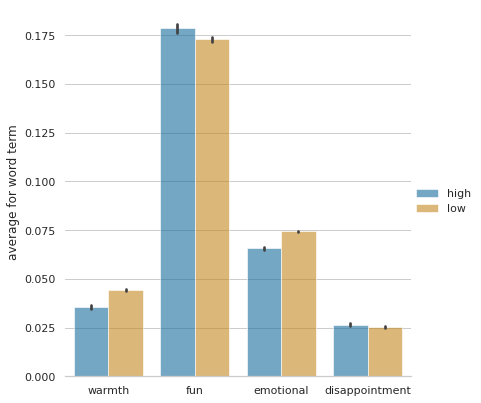

In [47]:
# Plot, for each sentiment category, the average score,
# depending on whether the movie was successful

g = sns.catplot(
    data=df_plot, kind="bar",
    x="category", y="value", hue="success",
    palette="colorblind", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "average for word term")
g.legend.set_title("")

(0.0, 0.5)

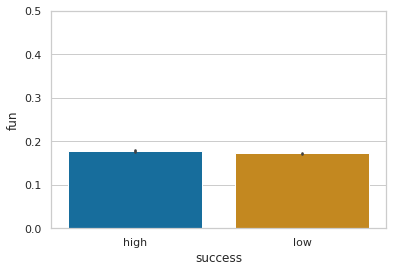

In [48]:
# Plot the fun score depending on the success of the movie
ax = sns.barplot(x="success", y="fun", palette="colorblind", data=df_final)
plt.ylim([0,0.5])

In [49]:
# Map each sentiment column to an int value
for sentiment in sentiments:
    df_final[sentiment] = df_final[sentiment].astype(int)

In [50]:
# Normalize each sentiment column value
for sentiment in sentiments:
    df_final[sentiment + "_st"] = (df_final[sentiment] - df_final[sentiment].mean()) / df_final[sentiment].std()

In [51]:
# Compute the log of each normalized value
for sentiment in sentiments:
    df_final['log_' + sentiment] = np.log(df_final[sentiment + '_st'] + 1)

In [54]:
# Expose binary column depending on the success of the movie
df_final["hit"] = df_final["success"].map(lambda v: 1 if v == "high" else 0)
df_final

,Unnamed: 0,quotation,speaker,date,numOccurrences,primaryTitle,startYear,genres,Total Gross,revenue,...,disappointment_st,love_st,hate_st,log_warmth,log_fun,log_emotional,log_disappointment,log_love,log_hate,hit
0,0,I want to clarify my interview on the `Charlie...,George Lucas,2015-12-31 16:48:00,7,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,...,-0.150521,1.853157,3.247112,-0.177729,1.470375,-0.271864,-0.163131,1.048426,1.446239,1
1,1,"It's the dawn of a new Star Wars era,",None,2015-12-18 12:55:59,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,1
2,2,"They were saying, `Well, since when has Star W...",J.J. Abrams,2015-12-21 08:04:49,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,1
3,3,Advertisers that used the force ahead of the S...,None,2015-12-16 22:57:43,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,1
4,4,The first Star Wars film was widely advertised...,Andy Summers,2015-12-16 05:13:50,1,Star Wars: Episode VII - The Force Awakens,2015.0,"Action,Adventure,Sci-Fi","$936,662,225",936662225,...,-0.150521,-0.318946,-0.209965,-0.177729,1.470375,-0.271864,-0.163131,-0.384113,-0.235678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932013,932013,evil versions of Wonder Woman and other member...,Barry Allen,2018-02-22 17:11:40,1,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,0
932014,932014,We saw a glimpse of it in the nightmare sequen...,Michael Wilkinson,2018-03-23 15:30:59,1,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,0
932015,932015,Will Australia get Justice League?,Owen Gleiberman,2018-04-16 13:57:35,2,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,0
932016,932016,Justice League has been the golden ring for me...,Scott Snyder,2018-03-19 13:03:21,10,Justice League,2017.0,"Action,Adventure,Fantasy","$229,024,295",229024295,...,-0.150521,-0.318946,-0.209965,-0.177729,-0.385861,-0.271864,-0.163131,-0.384113,-0.235678,0


In [56]:
# Try to find a relation between the success and the emotions in the quotes
# (or rather the log of the normalized values of the emotion scores)

#TO DO: plot some effects
formula = "hit ~ log_warmth + log_fun + log_emotional + log_disappointment + log_love + log_hate"
mod = smf.logit(formula=formula, data=df_final)
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.574349
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                    hit   No. Observations:               932018
Model:                          Logit   Df Residuals:                   932011
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Dec 2021   Pseudo R-squ.:               0.0004428
Time:                        03:33:53   Log-Likelihood:            -5.3530e+05
converged:                       True   LL-Null:                   -5.3554e+05
Covariance Type:            nonrobust   LLR p-value:                 2.858e-99
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0549      0.003   -345.925      0.000      -1.061      -1.049
log_w

In [57]:
model = smf.glm(formula=formula, data=df_final, family=sm.families.NegativeBinomial()).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    hit   No. Observations:               932018
Model:                            GLM   Df Residuals:                   932011
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.9987e+05
Date:                Fri, 17 Dec 2021   Deviance:                   5.2404e+05
Time:                        03:33:55   Pearson chi2:                 5.46e+05
No. Iterations:                     5   Pseudo R-squ. (CS):          0.0003035
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.3542      0.003   -459.236      0.000      -1.360      -1.348
log_warmth            -0.0770      0.007    -10.825      0.000      -0.091      -0.063
log_fun                0.0231      0.004      5.156      0.000       0.014       0.032
log_emotional         -0.0663      0.006    -11.354      0.000      -0.078      -0.055
log_disappointment     0.0155      0.007      2.218      0.027       0.002       0.029
log_love              -0.0073      0.005     -1.622      0.105      -0.016       0.002
log_hate               0.0186      0.006      3.042      0.002       0.007       0.031
======================================================================================
"""

In [58]:
# Display regression results
fam = Poisson()
y, X = patsy.dmatrices(formula, data=df_final, return_type='matrix')

p_model = sm.GLM(y, X, family=fam)

result = p_model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    hit   No. Observations:               932018
Model:                            GLM   Df Residuals:                   932011
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.7044e+05
Date:                Fri, 17 Dec 2021   Deviance:                   6.5346e+05
Time:                        03:33:59   Pearson chi2:                 6.88e+05
No. Iterations:                     6   Pseudo R-squ. (CS):          0.0003800
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.3543      0